<div>
<img src="https://www.nsstc.uah.edu/public/rwade/lis-data/Logo_header_nasa_lis_sport_arset.png" width="10000"/>

</div>

# **Application of NASA SPoRT-Land Information System (SPoRT-LIS) Soil Moisture Data for Drought**
# Session 3 - Python Jupyter Notebook
Authors: Robert Junod & Ryan Wade

Jupyter Notebook and data can be obtained from:

https://github.com/NASAARSET/SPoRT-LIS

https://geo.ndc.nasa.gov/SPoRT/modeling/lis/


The NASA Land Information System (LIS) is a flexible land surface modeling and data assimilation framework designed using advanced software engineering principles.  Structured to enable community sharing and the reuse of modeling tools, data resources, and assimilation algorithms, the LIS infrastructure provides modeling tools to integrate satellite- and ground-based observational data products and advanced land surface modeling techniques to produce optimal fields of land surface states and fluxes.

<div>
<img src="https://lis.gsfc.nasa.gov/sites/default/files/LIS/img/LIS_concept.gif" width="600"/>
</div>


The puropse of this module is to introduce users working with LIS data, with a focus on GeoTIFF georeferenced raster data Python framework. 


## <font color='red'> **Only run the following cell if you are using Google Colab** </font>
---

In [1]:
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy rioxarray
!apt-get -qq install python3-cartopy

!pip uninstall -y shapely    
!pip install shapely --no-binary shapely
#resolves conflicts between cartopy and shapely (issues since early 2020)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libproj-dev is already the newest version (7.2.1-1~focal0).
proj-bin is already the newest version (7.2.1-1~focal0).
proj-data is already the newest version (7.2.1-1~focal0).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.9.1-1~focal0).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found existing installation: Shapely 1.7.1
Uninstalling Shapely-1.7.1:
  Successfully uninstalled Shapely-1.7.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## **Required Imports and Colorscale Function**
---

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
from datetime import datetime as dt

import rioxarray as rxr
import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

The color maps below have been hard-code defined to match the LIS color scales on the NASA SPoRT Viewer

In [4]:
def get_LIS_cmap(output:str, file_str:str) -> ListedColormap:
  """ Make custom cmap, levels, and labels for LIS product
  
  Parameters
  ----------
  :param output: string defining the output product cmap
  :param file_str: string of input file to get labels

  Returns
  -------
  :returns: custom LIS cmap
  :returns: custom levels
  :returns: title string for plot
  
  """

  cdict = {'rsm': np.array(([0.549, 0.3922, 0.3529],
                           [0.7059, 0.549, 0.5098],
                           [0.8824, 0.7451, 0.7059],
                           [0.6471, 0.0, 0.0],
                           [0.8824, 0.0784, 0.0],
                           [1.0, 0.1961, 0.0],
                           [1.0, 0.3765, 0.0],
                           [1.0, 0.6275, 0.0],
                           [1.0, 0.7529, 0.2353],
                           [1.0, 0.9098, 0.4706],
                           [0.5882, 0.9608, 0.549],
                           [0.3137, 0.9412, 0.3137],
                           [0.1176, 0.7059, 0.1176],
                           [0.0784, 0.3922, 0.8235],
                           [0.1569, 0.5098, 0.9412],
                           [0.3137, 0.6471, 0.9608],
                           [0.5882, 0.8235, 0.9804],
                           [0.6275, 0.549, 1.0],
                           [0.4392, 0.3765, 0.8627],
                           [0.2353, 0.1569, 0.7059])),
           'vsm': np.array(([0.7059, 0.549, 0.5098],
                           [0.902, 0.4392, 0.4392],
                           [0.6471, 0.0, 0.0],
                           [0.7529, 0.0, 0.0],
                           [0.8824, 0.0784, 0.0],
                           [1.0, 0.1961, 0.0],
                           [1.0, 0.3765, 0.0],
                           [1.0, 0.6275, 0.0],
                           [1.0, 0.7529, 0.2353],
                           [1.0, 0.9098, 0.4706],
                           [0.5882, 0.9608, 0.549],
                           [0.3137, 0.9412, 0.3137],
                           [0.1176, 0.7059, 0.1176],
                           [0.1176, 0.4314, 0.9216],
                           [0.2353, 0.5882, 0.9608],
                           [0.4706, 0.7255, 0.9804])),
           'gvf': np.array(([0.4706, 0.3137, 0.2745],
                           [0.6275, 0.4706, 0.4314],
                           [0.7843, 0.6275, 0.5882],
                           [1.0, 0.9098, 0.4706],
                           [0.6275, 0.902, 0.1961],
                           [0.7059, 0.9804, 0.6667],
                           [0.4706, 0.9608, 0.451],
                           [0.2157, 0.8235, 0.2353],
                           [0.1176, 0.7059, 0.1176],
                           [0.0588, 0.6275, 0.0588])),
           'chg': np.array(([0.3922, 0.2353, 0.1961],
                           [0.549, 0.3922, 0.3529],
                           [0.7059, 0.549, 0.5098],
                           [0.8824, 0.7451, 0.7059],
                           [0.9725, 0.6275, 0.6275],
                           [0.6471, 0.0, 0.0],
                           [0.8824, 0.0784, 0.0],
                           [1.0, 0.3765, 0.0],
                           [1.0, 0.7529, 0.2353],
                           [1.0, 0.9804, 0.6667],
                           [0.7059, 0.7059, 0.7059],
                           [0.5882, 0.9608, 0.549],
                           [0.3137, 0.9412, 0.3137],
                           [0.1176, 0.7059, 0.1176],
                           [0.1176, 0.4314, 0.9216],
                           [0.2353, 0.5882, 0.9608],
                           [0.4706, 0.7255, 0.9804],
                           [0.7059, 0.9412, 0.9804],
                           [0.502, 0.4392, 0.9216],
                           [0.2824, 0.2353, 0.7843],
                           [0.1765, 0.1176, 0.6471])),
           'per': np.array(([0.4196,0.0000,0.0000],
                            [0.9216,0.0000,0.0000],
                            [0.9216,0.4588,0.0000],
                            [1.0000,0.7020,0.4000],
                            [1.0000,1.0000,0.4000],
                            [0.7843,0.7843,0.7843],
                            [0.8863,1.0000,1.0000],
                            [0.5961,0.8235,0.9765],
                            [0.3294,0.6510,0.9529],
                            [0.1882,0.5137,0.9294],
                            [29/255.,101/255.,207/255.]))
           }
  level_dict = {'rsm': np.arange(5,96,5),
                'vsm': np.arange(3,46,3),
                'gvf': np.array([10,20,30,40,50,60,70,80,90.]),
                'chg': np.array([-32, -28, -24, -20, -16, -12, -8, -4, -2, -0.1,
                                 0.1, 2, 4, 8, 12, 16, 20, 24, 28, 32]),
                'per': np.array([2,5,10,20,30,70,80,90,95,98])}


  _date = dt.strptime(file_str.split('/')[-1][:8],'%Y%m%d')
  _hour = dt.strptime(file_str.split('/')[-1][9:13],'%H%M')
  _product = file_str.split('/')[-2]
  _ptype = file_str.split('/')[-1].split('_')[4]


  title_dict = {'rsm': f'{_product} (available water; %) valid {_hour:%H}Z'
                       f'{_date:%m-%d-%Y}',
                'vsm': f'{_product} (%) valid {_hour:%H}Z {_date:%m-%d-%Y}',
                'gvf': f'Green Vegetation Fraction (%) valid {_date:%m-%d-%Y}',
                'chg': f'{" ".join(_product.split("_"))} Difference (%) valid '
                       f'{_hour:%H}Z {_date:%m-%d-%Y}',
                'per': f'{_ptype} Percentile valid {_date:%m-%d-%Y}'}
  
  # Set cmap colorbar by product type
  # - set under, over, and bad values as well  
  _cmap = ListedColormap(cdict[output][1:-1])
  _cmap.set_bad(color=(1,1,1))
  _cmap.set_over(color=cdict[output][-1])
  _cmap.set_under(color=cdict[output][0])

  return _cmap, level_dict[output], title_dict[output]

## **Readin NASA SPoRT LIS data and plot**
---

 # **Drought Monitor Example - Arkansas, USA - Sept 2022**

You are a drought monitor author who wants to create your own visualization of NASA SPoRT-LIS data. Your goal is to create a CONUS view (similar to the U.S. Drought Monitor maps) of Volumetric Soil Moisture Percentile to aid in your analysis. 

<div>
<img src="https://droughtmonitor.unl.edu/data/png/20220927/20220927_usdm.png" width="800"/>
</div>



You start by downloading & reading-in SPoRT-LIS data (GeoTIFF), specifically the 0-10cm VSM Percentile product. This can be done through NASA MSFC SPoRT's geo server. Archived data is listed at the links below, while "live" SPoRT-LIS data can be accessed in the following directory:  https://geo.ndc.nasa.gov/SPoRT/modeling/lis/conus3km/geotiff/

In [5]:
geo_url = 'https://github.com/ryanwadewx/sport-lis/raw/main/sample_data/conus/vsm_percentiles/'

# VSM 0-10cm percentile
file_in = geo_url + '20220930_0000_sport_lis_vsm0-10cm_percentile_conus3km_float_wgs84.tif'
ptype = 'per'

ds = rxr.open_rasterio(file_in) if ptype != 'vsm' else rxr.open_rasterio(file_in) * 100.
# Mask any nodata values
ds = ds.where(ds < 9999).copy()

> <font size=5> 🗒 **Note for Readin** </font>: 

Read in different LIS products a similar way by copy & pasting the sections for each product from below.

>```python
># VSM 0-10cm percentile  (Volumetric Soil Moisture Percentile)
file_in = geo_url + '20220930_0000_sport_lis_vsm0-10cm_percentile_conus3km_float_wgs84.tif'
ptype = 'per'
```
>```python
># RSM 0-10cm  (Relative Soil Moisture)
file_in = geo_url + 'rsm_0-10cm/20230130_0000_sport_lis_rsm0-10cm_conus3km_float_wgs84.tif'
ptype = 'rsm'
```
>```python
># VSM 0-10cm   (Volumetric Soil Moisture)
file_in = geo_url + 'vsm_0-10cm/20230501_0000_sport_lis_vsm0-10cm_conus3km_float_wgs84.tif'
ptype = 'vsm'
```
>```python
> # GVF   (Green Vegatation Fraction)
file_in = geo_url + 'gvf/20230130_0000_sport_lis_gvf_conus3km_float_wgs84.tif'
ptype = 'gvf'
```
>```python
> # RSM 0-2m 14 day difference   (Relative Soil Moisture Difference)
file_in = geo_url + 'rsm_0-2m_diff14day/20230130_0000_sport_lis_rsm0-2m_diff14day_conus3km_float_wgs84.tif'
ptype = 'chg'
```

### **Plot CONUS LIS Data**

Text(0.5, 1.0, 'vsm0-10cm Percentile valid 09-30-2022')

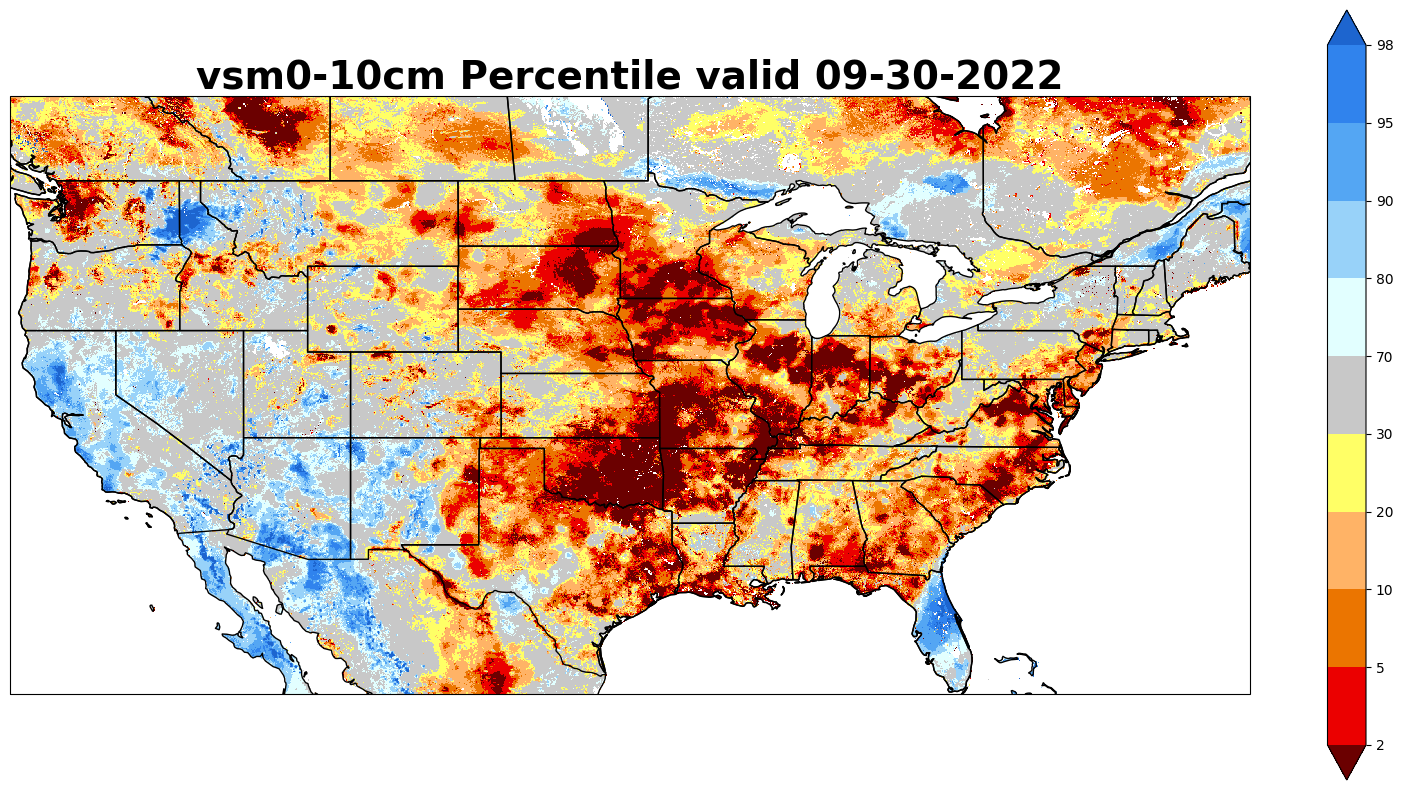

In [6]:
cmap_LIS, levels, tlabel = get_LIS_cmap(ptype, file_in)
fig, ax = plt.subplots(figsize=(20,10),subplot_kw={'projection':ccrs.PlateCarree()})
map = ds.squeeze().plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap_LIS,
                        # vmin=10, vmax=90,
                        norm= BoundaryNorm(levels, cmap_LIS.N),
                        extend='both',
                        cbar_kwargs={'ticks': levels})
ax.coastlines()
ax.add_feature(cf.STATES)
ax.set_title(label=tlabel, fontdict={'fontsize': 28,'fontweight': 'bold'})

**Session 2 Drought Monitor Example - Arkansas, USA - Sept 2022**

**Zoomed in View**

USDM authors considering whether to include central Arkansas in D2 Severe Drought category. Based on this need, you decide to create a zoomed in view for Arkansas with counties to increase the specificity of the visualization. 

<div>
<img src="https://droughtmonitor.unl.edu/data/png/20220927/20220927_ar_trd.png" width="800"/>
</div>

County-based shapefiles needed for zoomed-in view. Download and readin county-based shapefiles for the United States. 


In [7]:
#download and readin U.S. county shapefile for use in state-leve zoom
reader = shpreader.Reader('https://www.nsstc.uah.edu/public/rwade/lis-data/countyl010g_shp_nt00964/countyl010g.shp')
counties = list(reader.geometries())
COUNTIES = cf.ShapelyFeature(counties, ccrs.PlateCarree())

Create plot, set color map, overlay coastlines and county boundaries onto previously readin SPoRT LIS Volumetric Soil Moisture. 

Set the custom bounds for zoomed-in view based on latitutes 32N to 37N, longitudes 95W to 89W. 

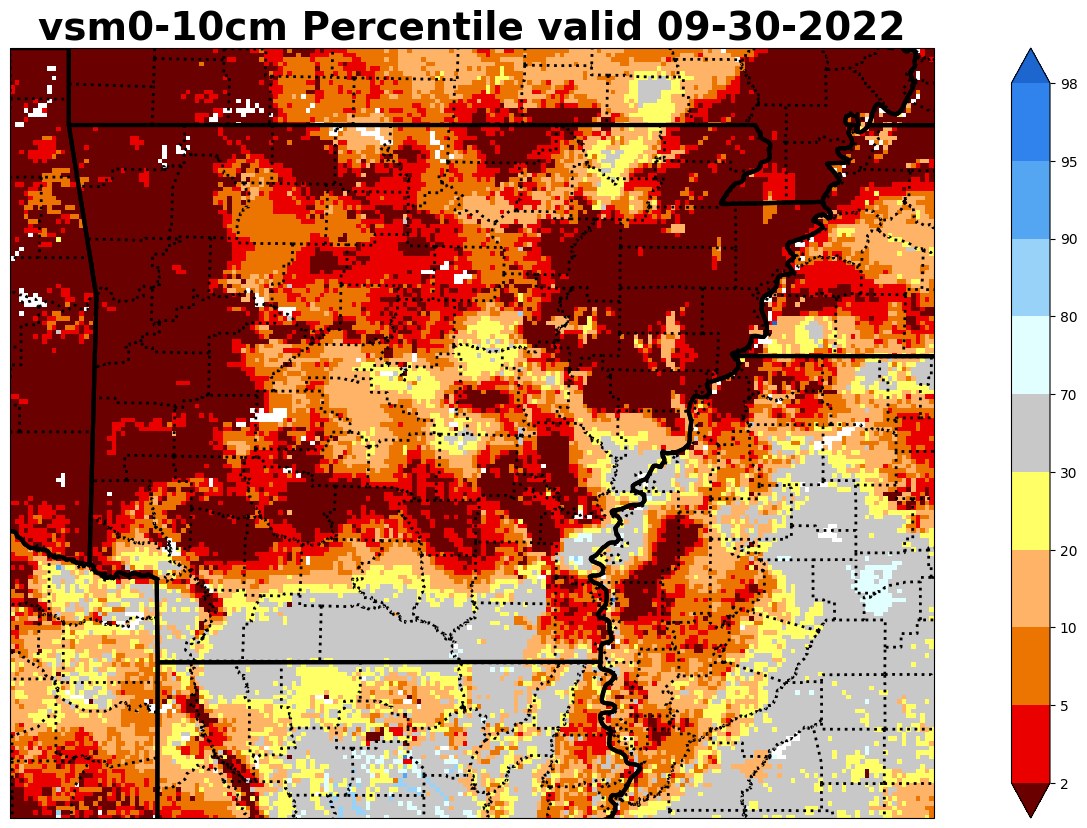

In [8]:
cmap_LIS, levels, tlabel = get_LIS_cmap(ptype, file_in)
fig, ax = plt.subplots(figsize=(20,10),subplot_kw={'projection':ccrs.PlateCarree()})
map = ds.squeeze().plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap_LIS,
                        # vmin=10, vmax=90,
                        norm= BoundaryNorm(levels, cmap_LIS.N),
                        extend='both',
                        cbar_kwargs={'ticks': levels})
ax.coastlines()
ax.add_feature(cf.STATES, linewidth=3)
ax.add_feature(COUNTIES, linestyle=':', linewidth=2, facecolor='none', edgecolor='black')
ax.set_title(label=tlabel, fontdict={'fontsize': 28,'fontweight': 'bold'})
#set custom bounds for plot
ax.set_extent([-95,-89,32,37])

# Create a 4-Panel plot for available SPoRT-LIS Volumetric Soil Moisture depths

The initial plot of VSM percentiles (0-10cm) is mostly relavent for short-term impacts of precipitation on soil moisture since it is the most shallow layer available. In order to further analyze soil moisture depth for drought impacts, you decide to set up a 4-panel plot of the following products: 

0-10cm VSM Percentiles

0-40cm VSM Percentiles

0-100cm VSM Percentiles

0-200cm VSM Percentiles

Download data for the VSM 0-10cm, 0-40cm, 0-100cm, & 0-200cm depths:

In [9]:
# For panel plot for percentiles
per_depths = ['10cm','40cm','100cm','200cm']
files = [f'{geo_url}20220930_0000_sport_lis_vsm0-{depth}_percentile_conus3km_float_wgs84.tif' for depth in per_depths]
lis_dict = {'per_'+k:rxr.open_rasterio(file) for (k,file) in zip(per_depths,files)}

Define a dictionary for LIS data inputs and products for the 4-panel plot:

In [10]:
def panel_plot(lis_dict:dict, _ptype:str, _files:list, counties) -> str:
  """ Make four panel plot from LIS data
  
  Parameters
  ----------
  :param lis_dict: dictionary of lis data inputs
  :param _ptype: string of LIS product type
  :param _files: list of files of _ptype

  Returns
  -------
  :returns: string of success
  
  """

  # Checks to make sure there are only 4 data inputs
  assert len(lis_dict.keys()) == 4, 'Incorrect number of data inputs, try again!'

  fig, ax = plt.subplots(figsize=(12,10), nrows=2, ncols=2,
                           subplot_kw={'projection':ccrs.PlateCarree()})

  for i,data in enumerate(lis_dict.keys()):
    _data = lis_dict[data].where(lis_dict[data] < 9999).copy()
    _cmap, _levels, _tlabel = get_LIS_cmap(_ptype, _files[i])
    map = _data.squeeze().plot(ax=ax[i//2,i%2], transform=ccrs.PlateCarree(), cmap=_cmap,
                              norm= BoundaryNorm(_levels, _cmap.N),
                              add_colorbar=False)
    ax[i//2,i%2].coastlines()
    ax[i//2,i%2].add_feature(cf.STATES, linewidth=3)
    ax[i//2,i%2].add_feature(counties, linestyle=':', linewidth=2, facecolor='none', edgecolor='black')
    ax[i//2,i%2].set_title(label=_tlabel, fontdict={'fontsize': 12,'fontweight': 'bold'})
    #set custom bounds for plot
    ax[i//2,i%2].set_extent([-95,-89,32,37])

  cax = fig.add_axes([0.95,0.10,0.03,0.75])
  cbar = fig.colorbar(map, cax=cax,orientation='vertical',
                      label='Percentile', extend='both', ticks= _levels)
  
  return 'Plot Success!'
  





Execute the 4-panel plot:

'Plot Success!'

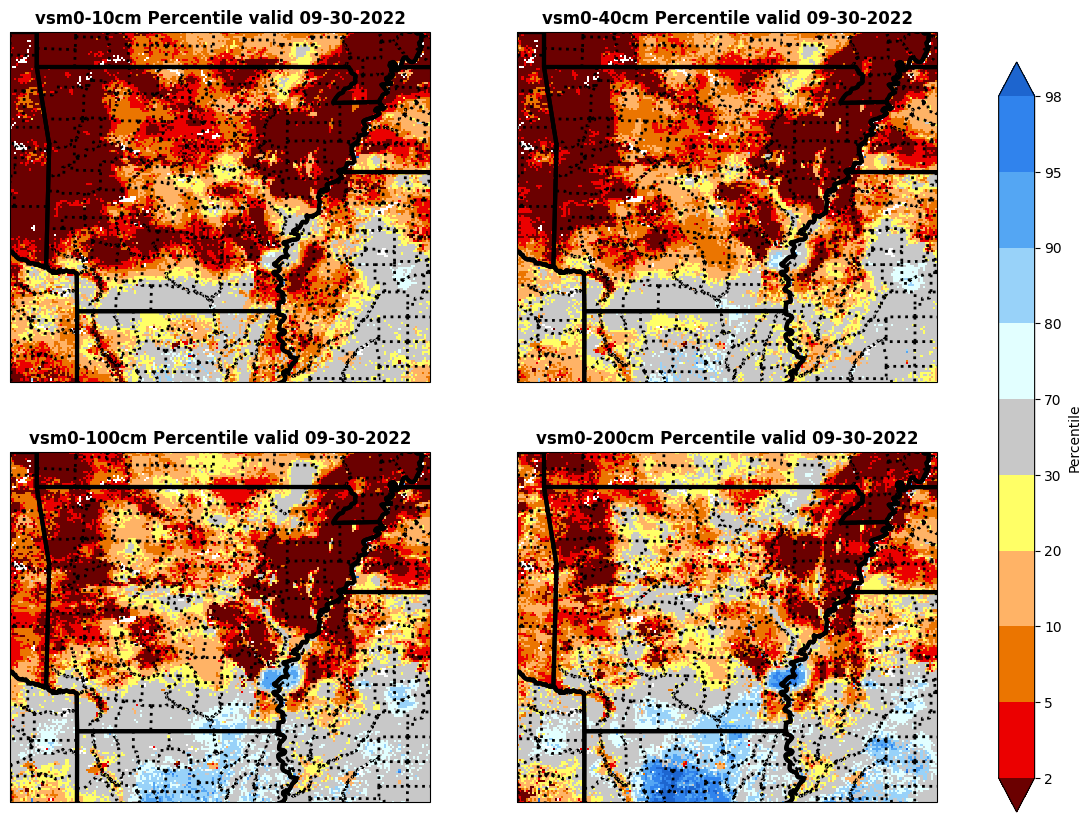

In [11]:
# Panel plot
panel_plot(lis_dict,'per',files, COUNTIES)

# **International Examples**

### **Plot Africa LIS Data**

You are interested in created Relative Soil Moisture (RSM) plots for all of Africa, then create a custom zoom similar to the LIS images on the NASA SPoRT Viewer.

Readin RSM data for Africa

In [12]:
geo_url = 'https://github.com/ryanwadewx/sport-lis/raw/main/sample_data/africa/'
# RSM 0-10cm
# file_in = geo_url + 'rsm_0-10cm/20230130_0000_sport_lis_rsm0-10cm_conus3km_float_wgs84.tif'
# ptype = 'rsm'

# RSM 10-40cm
file_in = geo_url + 'rsm10-40cm/20211101_0000_sport_lis_rsm10-40cm_allafrica_3km_float_wgs84.tif'
ptype = 'rsm'

# GVF
#file_in = geo_url + 'gvf/20230130_0000_sport_lis_gvf_conus3km_float_wgs84.tif'
#ptype = 'gvf'

# RSM 0-2m 14 day difference
#file_in = geo_url + 'rsm_0-2m_diff14day/20230130_0000_sport_lis_rsm0-2m_diff14day_conus3km_float_wgs84.tif'
#ptype = 'chg'

# VSM 0-10cm percentile
# file_in = geo_url + 'vsm_percentiles/20230130_0000_sport_lis_vsm0-10cm_percentile_conus3km_float_wgs84.tif'
# ptype = 'per'

ds = rxr.open_rasterio(file_in) if ptype != 'vsm' else rxr.open_rasterio(file_in) * 100.
# Mask any nodata values
ds = ds.where(ds < 9999).copy()

Text(0.5, 1.0, 'rsm10-40cm (available water; %) valid 00Z11-01-2021')

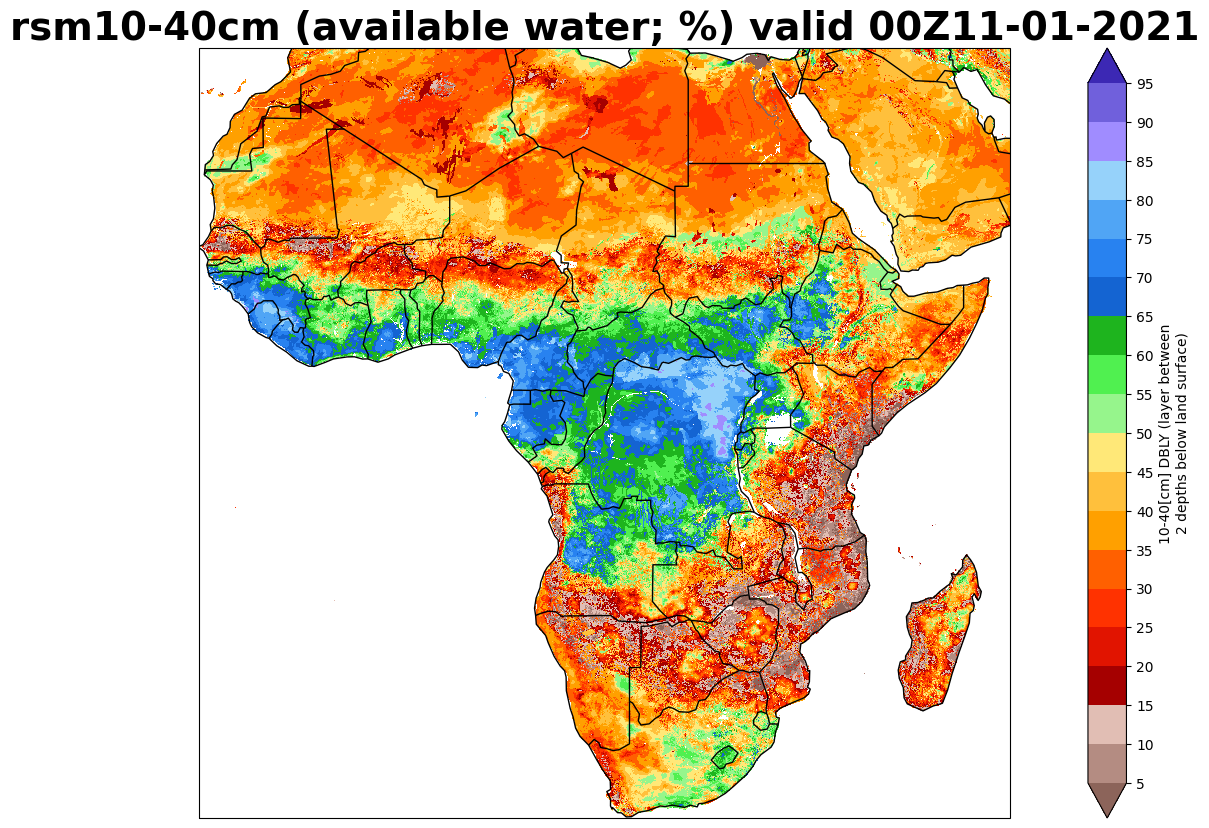

In [13]:
cmap_LIS, levels, tlabel = get_LIS_cmap(ptype, file_in)
fig, ax = plt.subplots(figsize=(20,10),subplot_kw={'projection':ccrs.PlateCarree()})
map = ds.squeeze().plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap_LIS,
                        # vmin=10, vmax=90,
                        norm= BoundaryNorm(levels, cmap_LIS.N),
                        extend='both',
                        cbar_kwargs={'ticks': levels})
ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.set_title(label=tlabel, fontdict={'fontsize': 28,'fontweight': 'bold'})

**SPoRT LIS Africa Example**
**Zoomed in View**

<div>
<img src="https://www.nsstc.uah.edu/public/rwade/lis-data/rsoim0-10_20230501_15z_africa.gif" width="800"/>
</div>

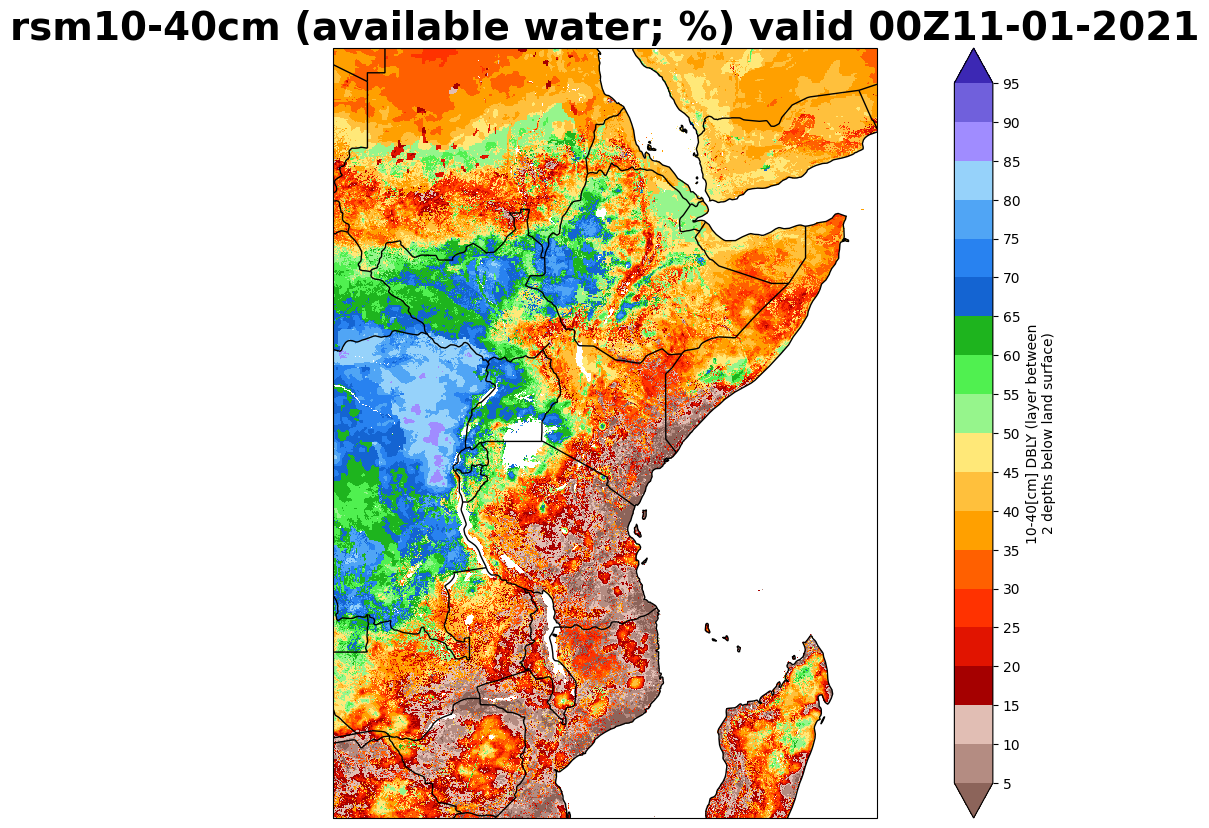

In [14]:
cmap_LIS, levels, tlabel = get_LIS_cmap(ptype, file_in)
fig, ax = plt.subplots(figsize=(20,10),subplot_kw={'projection':ccrs.PlateCarree()})
map = ds.squeeze().plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap_LIS,
                        # vmin=10, vmax=90,
                        norm= BoundaryNorm(levels, cmap_LIS.N),
                        extend='both',
                        cbar_kwargs={'ticks': levels})
ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.set_title(label=tlabel, fontdict={'fontsize': 28,'fontweight': 'bold'})

#set custom bounds for plot
ax.set_extent([22,53,-22,21])

### **SPoRT LIS Custom Differencing Example**

1-Month Difference

Below you see a 1-month difference plot of total column Relative Soil Moisture (0-2m) taken from the NASA SPoRT Viewer.  You want to create your own custom difference plots of 1-week and 2-week change in total column Relative Soil Moisture, but those plots and data files are not readily available. 

<div>
<img src="https://weather.ndc.nasa.gov/sport/dynamic/lis_CONUS/swetdiff30_20230501_12z_conus.gif" width="800"/>
</div>


Readin data for a 1-week RSM 0-2m Difference Plot between 2022-09-30 and 2022-09-23:

In [15]:
geo_url = 'https://github.com/ryanwadewx/sport-lis/raw/main/sample_data/conus/rsm_0-2m/'

#RSM 0-2m file 1
file_in1 = geo_url + '20220930_0000_sport_lis_rsm0-2m_conus3km_float_wgs84.tif'
ptype = 'rsm'

ds1 = rxr.open_rasterio(file_in1) if ptype != 'vsm' else rxr.open_rasterio(file_in1) * 100.
# Mask any nodata values
ds1 = ds1.where(ds1 < 9999).copy()


#RSM 0-2m file 2
file_in2 = geo_url + '20220923_0000_sport_lis_rsm0-2m_conus3km_float_wgs84.tif'
ptype = 'rsm'


ds2 = rxr.open_rasterio(file_in2) if ptype != 'vsm' else rxr.open_rasterio(file_in2) * 100.
# Mask any nodata values
ds2 = ds2.where(ds2 < 9999).copy()

ds3 = ds1 - ds2
ptype = 'chg'




Create a 1-week RSM 0-2m Difference Plot between 2022-09-30 and 2022-09-23:

Text(0.5, 1.0, 'rsm 0-2m Difference (%) valid 00Z 09-30-2022')

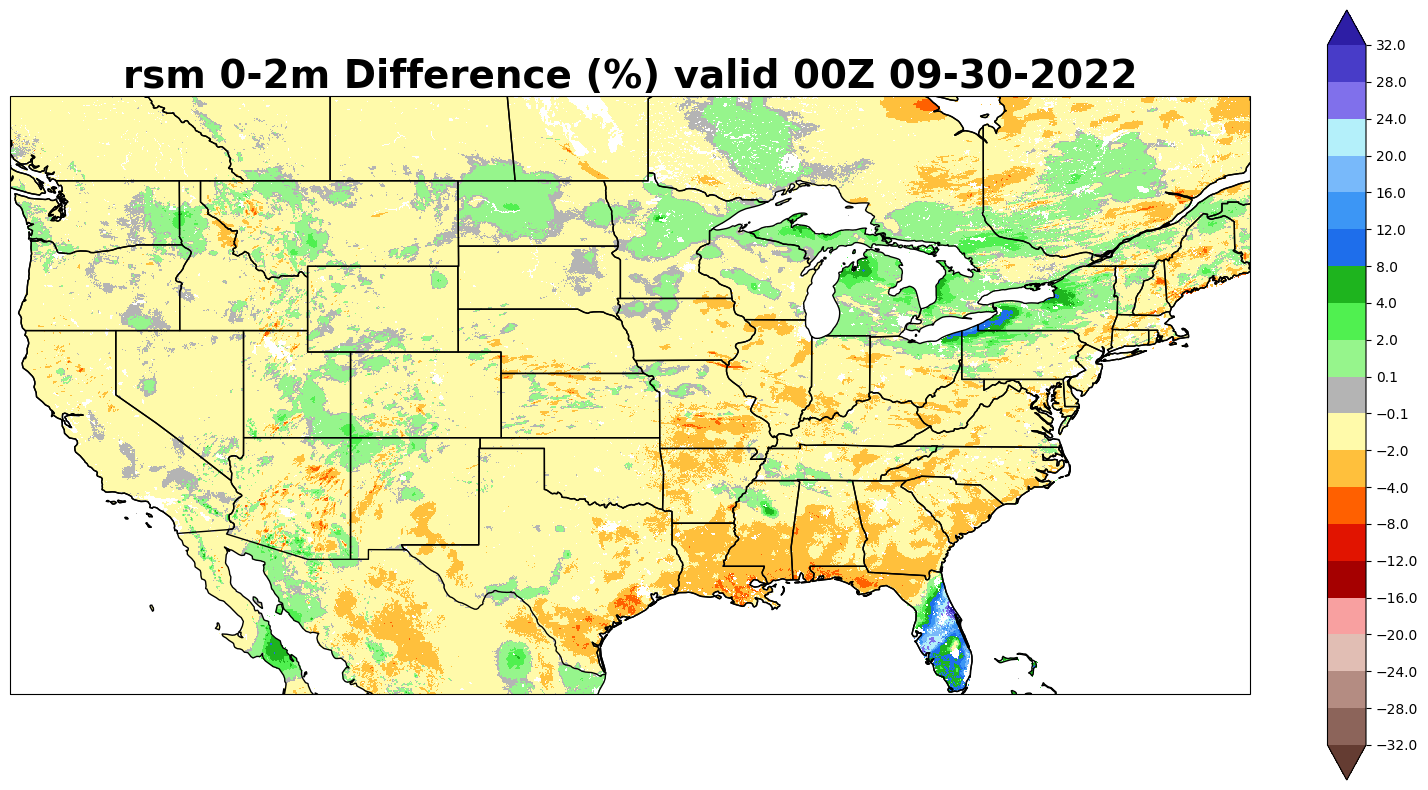

In [16]:
cmap_LIS, levels, tlabel = get_LIS_cmap(ptype, file_in1)
fig, ax = plt.subplots(figsize=(20,10),subplot_kw={'projection':ccrs.PlateCarree()})
map = ds3.squeeze().plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap_LIS,
                        # vmin=10, vmax=90,
                        norm= BoundaryNorm(levels, cmap_LIS.N),
                        extend='both',
                        cbar_kwargs={'ticks': levels})
ax.coastlines()
ax.add_feature(cf.STATES)
ax.set_title(label=tlabel, fontdict={'fontsize': 28,'fontweight': 'bold'})

#set custom bounds for plot
#ax.set_extent([-120,-75,25,50])

Create a 2-week RSM 0-2m Difference Plot between 2022-09-30 and 2022-09-16:

Text(0.5, 1.0, 'rsm 0-2m Difference (%) valid 00Z 09-30-2022')

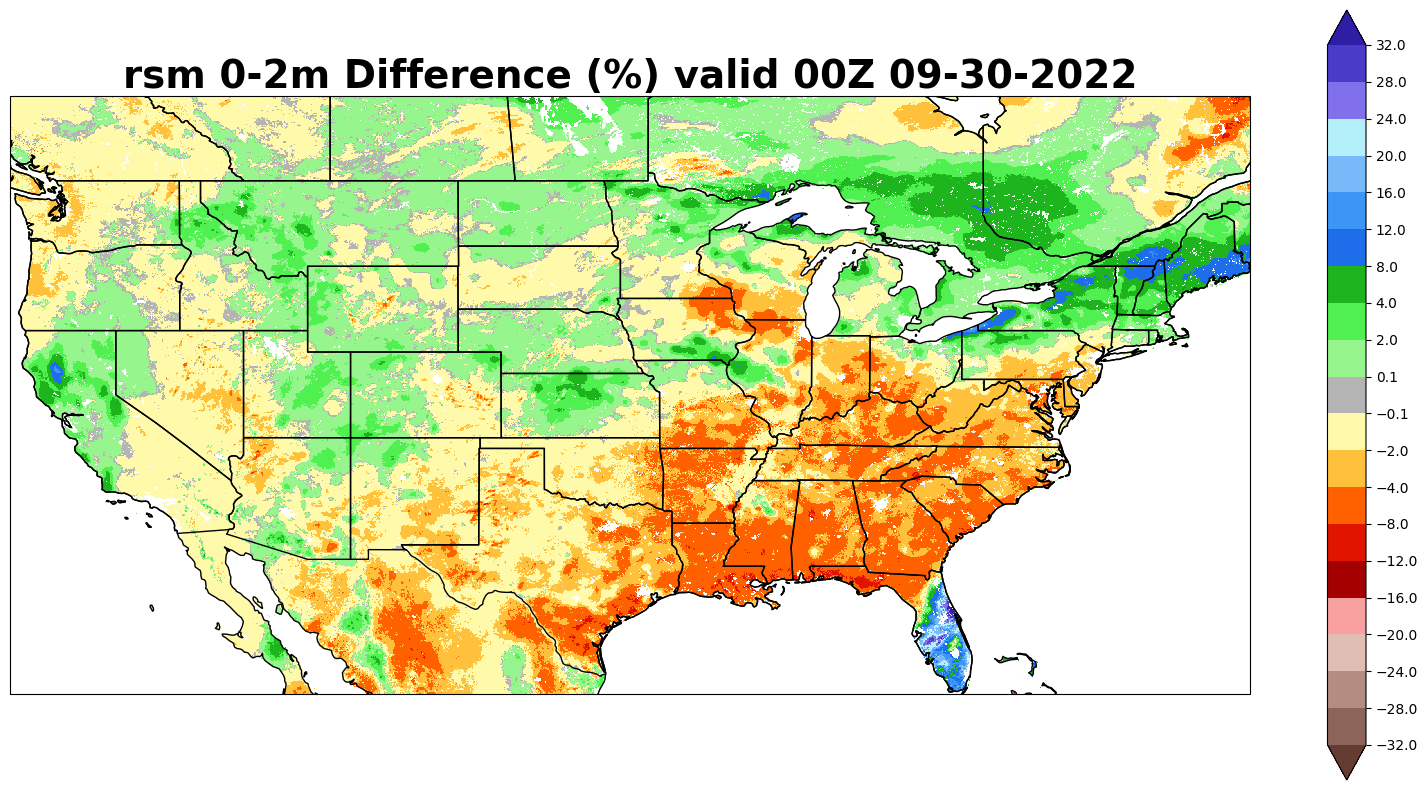

In [17]:
geo_url = 'https://github.com/ryanwadewx/sport-lis/raw/main/sample_data/conus/rsm_0-2m/'

#RSM 0-2m file 1
file_in1 = geo_url + '20220930_0000_sport_lis_rsm0-2m_conus3km_float_wgs84.tif'
ptype = 'rsm'

ds1 = rxr.open_rasterio(file_in1) if ptype != 'vsm' else rxr.open_rasterio(file_in1) * 100.
# Mask any nodata values
ds1 = ds1.where(ds1 < 9999).copy()


#RSM 0-2m file 2
file_in2 = geo_url + '20220916_0000_sport_lis_rsm0-2m_conus3km_float_wgs84.tif'
ptype = 'rsm'


ds2 = rxr.open_rasterio(file_in2) if ptype != 'vsm' else rxr.open_rasterio(file_in2) * 100.
# Mask any nodata values
ds2 = ds2.where(ds2 < 9999).copy()

ds3 = ds1 - ds2
ptype = 'chg'

cmap_LIS, levels, tlabel = get_LIS_cmap(ptype, file_in1)
fig, ax = plt.subplots(figsize=(20,10),subplot_kw={'projection':ccrs.PlateCarree()})
map = ds3.squeeze().plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap_LIS,
                        # vmin=10, vmax=90,
                        norm= BoundaryNorm(levels, cmap_LIS.N),
                        extend='both',
                        cbar_kwargs={'ticks': levels})
ax.coastlines()
ax.add_feature(cf.STATES)
ax.set_title(label=tlabel, fontdict={'fontsize': 28,'fontweight': 'bold'})

#set custom bounds for plot
#ax.set_extent([-120,-75,25,50])